# H05  - Rethinking - Prosocial chimpanzees

# 2023-05-15

## Data, explanation and code from Richard McElreath (2020),   
## _"Statistical Rethinking - 2nd ed"_  (Chapters 11 and 13)

# Prosocial chimpanzees

The data for this example come from an experiment ($\star$) aimed at evaluating the prosocial tendencies of chimpanzees _(Pan troglodytes)._ The experimental structure mimics many common experiments conducted on human students _(Homo sapiens studiensis)_ by economists and psychologists. 

($\star$) Joan B. Silk _et al._ (2005), _"Chimpanzees are indifferent to the welfare of unrelated group members",_ Nature, **437,** 1357-1359. 

One year later there was a contesting paper: Beninger _et al._ (2006), _"Chimpanzee choice and prosociality",_ Nature **440,** E6,   
and a reply from the original authors,_ Nature **440,** (same E6 page).

A focal chimpanzee _(not shown in the picture, meant to represent its point-of-view)_ sits at one end of a long table with two levers, one on the left and one on the right:

<figure>
<Center><img src="Img/Chimpanzees.jpg" style= "width:8cm;height:8m"/>
<figcaption>
Figure   11.2.  Chimpanzee   prosociality experiment, as seen from the perspective of  the  focal animal.   
<p>The  left  and  right levers  are  indicated  in  the  foreground.</p>
<p>Pulling  either expands  an  accordion  device in the center, pushing the food trays towards both ends of the table.</p>
<p>Both food trays close to the focal animal have food in them.</p>
<p>Only one of the food trays on the other side contains food.</p>
<p>The partner condition means another animal, as pictured, sits on the other end of the table.</p>
<p>Otherwise the other end was empty.</p>
</figcaption></Center>
</figure>

On the table are four dishes which may contain desirable food items.

The two dishes on the right side of the table are attached by a mechanism to the right-hand lever. 

The two dishes on the left side are similarly attached to the left-hand lever.

When either the left or right lever is pulled by the focal animal, the two dishes on the same side slide towards opposite ends of the table. This delivers whatever is in those dishes to the opposite ends. In all experimental trials, both dishes on the focal animal's side contain food items. But only one of the dishes on the other side of the table contains a food item.

Therefore while both levers deliver food to the focal animal, only one of the levers delivers food to the other side of the table. There are two experimental conditions. 

1. In the partner condition, another chimpanzee is seated at the opposite end of the table, _(as shown in the picture)._ 
2. In the control condition, the other side of the table is empty. Finally, two counterbalancing treatments alternate which side, left or right, has a food item for the other side of the table. This helps detect any handedness preferences for individual focal animals.

When human students participate in an experiment like this, they nearly always choose the lever linked to two pieces of food, the _prosocial option,_ but only when another student sits on the opposite side of the table. The motivating question is whether a focal chimpanzee behaves similarly, choosing the prosocial option more often when another animal is present.

In terms of linear models, we want to estimate the interaction between condition (presence or absence of another animal) and option (which side is prosocial).

In [1]:
#install.packages(c("coda","mvtnorm","devtools","loo","dagitty"))
#require(devtools)
#devtools::install_github("rmcelreath/rethinking")

## R code 11.1
require(rethinking,quietly=TRUE)


rstan version 2.26.13 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file

This is cmdstanr version 0.5.3

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: C:/R/R-4.3.0/.cmdstan/cmdstan-2.32.1

- CmdStan version: 2.32.1

rethinking (Version 2.31)


Attaching package: 'rethinking'


The following object is masked from 'package:rstan':

    stan


The following object is masked from 'package:stats':

    rstudent




In [2]:
#set_cmdstan_path("C:/R/R-4.3.0/.cmdstan/cmdstan-2.32.1")
set_ulam_cmdstan(FALSE)

## Chimpanzee prosocialty experiment data

### Description

Data from behavior trials in a captive group of chimpanzees, housed in Lousiana. From Silk et al. 2005. Nature 437:1357-1359.

### Format

01. `actor`:          name of actor
01. `recipient`:      name of recipient (NA for partner absent condition)
03. `condition`:      partner absent (0), partner present (1)
04. `block`:          block of trials (each actor x each recipient 1 time)
05. `trial`:          trial number (by chimp = ordinal sequence of trials for each chimp, ranges from 1-72; partner present trials were interspersed with partner absent trials)
06. `prosocial_left`: 1 if prosocial (1/1) option was on left
07. `chose_prosoc`:   choice chimp made (0 = 1/0 option, 1 = 1/1 option)
08. `pulled_left`:    which side did chimp pull (1 = left, 0 = right)

### Author(s)

Richard McElreath

### References

Silk et al. 2005. Nature 437:1357-1359

In [3]:
data(chimpanzees)
d <- chimpanzees
str(d)

'data.frame':	504 obs. of  8 variables:
 $ actor       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ recipient   : int  NA NA NA NA NA NA NA NA NA NA ...
 $ condition   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ block       : int  1 1 1 1 1 1 2 2 2 2 ...
 $ trial       : int  2 4 6 8 10 12 14 16 18 20 ...
 $ prosoc_left : int  0 0 1 0 1 1 1 1 0 0 ...
 $ chose_prosoc: int  1 0 0 1 1 1 0 0 1 1 ...
 $ pulled_left : int  0 1 0 0 1 1 0 0 0 0 ...


We're going to focus on `pulled_left` as the outcome to predict, with `prosoc_left` and `condition` as predictor variables. The outcome pulled_left is a 0 or 1 indicator that the focal animal pulled the left-hand lever. 

The predictor `prosoc_left` is a 0/1 indicator that the left-hand lever was (1) or was not (0) attached to the prosocial option, the side with two pieces of food. The `condition` predictor is another 0/1 indicator, with value 1 for the partner
condition and value 0 for the control condition.

We'll want to infer what happens in each combination of prosoc_left and condition. There are four combinations:

1.   `prosoc_left`= 0 and `condition`= 0: Two food items on right and no partner.
2.   `prosoc_left`= 1 and `condition`= 0: Two food items on left and no partner.
3.   `prosoc_left`= 0 and `condition`= 1: Two food items on right and partner present.
4.   `prosoc_left`= 1 and `condition`= 1: Two food items on left and partner present.

We build an index variable containing the values 1 through 4, to index the combinations above. A very quick way to do
this is:

In [4]:
## R code 11.2
d$treatment <- 1 + d$prosoc_left + 2*d$condition

The Figure above shows an instance of **Condition 3:** Two food items on right and partner present. 

In [5]:
## R code 11.3
xtabs( ~ treatment + prosoc_left + condition , d )

, , condition = 0

         prosoc_left
treatment   0   1
        1 126   0
        2   0 126
        3   0   0
        4   0   0

, , condition = 1

         prosoc_left
treatment   0   1
        1   0   0
        2   0   0
        3 126   0
        4   0 126


# Logistic regression model 01 - Laplace approximation

$$
\mskip-500mu
    \begin{array}{lcl}
        L_{i}                       &\sim &\operatorname{Binomial}(1; p_{i}),\\[0.25cm]
        \operatorname{logit}(p_{i}) &=    &\alpha,\\[0.25cm]
        \alpha                      &\sim &\operatorname{Normal}(0; \omega).
    \end{array}
$$

Flat prior: $\omega=10$ 

In [6]:
## R code 11.4
m11.1 <- quap(
    alist(
        pulled_left ~ dbinom( 1 , p ) ,
        logit(p) <- a ,
        a ~ dnorm( 0 , 1.5 )
    ) , data=d )

In [7]:
## R code 11.5
set.seed(1999)
prior <- extract.prior( m11.1 , n=1e4 )

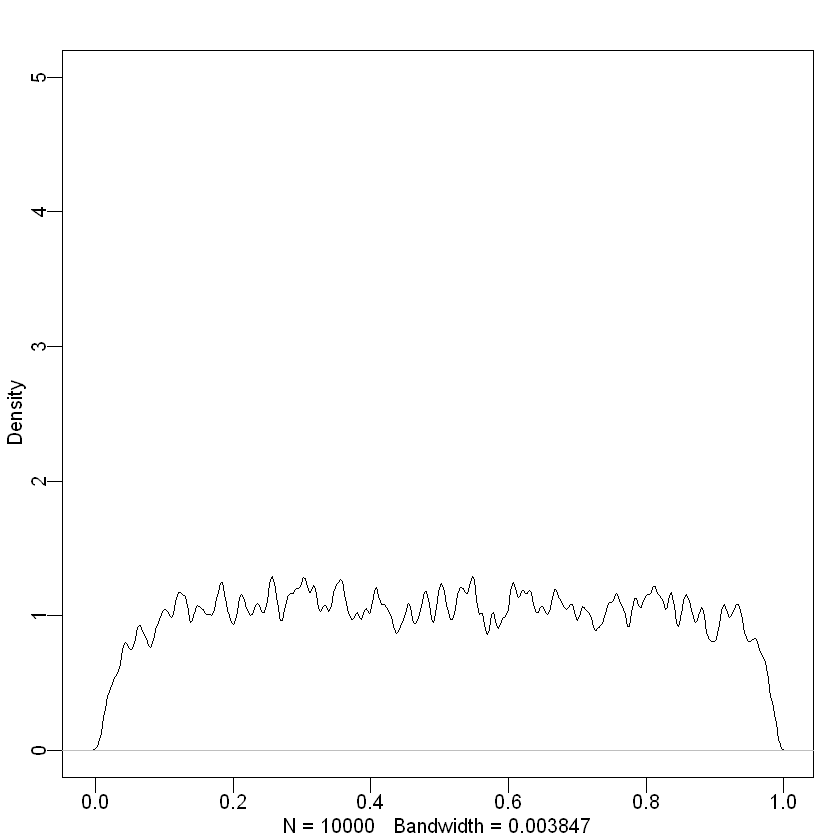

In [8]:
## R code 11.6
p <- inv_logit( prior$a )
options(repr.plot.width=7,repr.plot.height=7)
dens( p , adj=0.1 ,ylim=c(0,5))

# Logistic regression model 02 - Laplace approximation

We introduce a treatment coefficient `b` (with different values for each of the 4 possible treatments)

In [9]:
## R code 11.7
m11.2 <- quap(
    alist(
        pulled_left ~ dbinom( 1 , p ) ,
        logit(p) <- a + b[treatment] ,
        a ~ dnorm( 0 , 1.5 ),
        b[treatment] ~ dnorm( 0 , 10 )
    ) , data=d )

In [10]:
set.seed(1999)
prior <- extract.prior( m11.2 , n=1e4 )
p <- sapply( 1:4 , function(k) inv_logit( prior$a + prior$b[,k] ) )

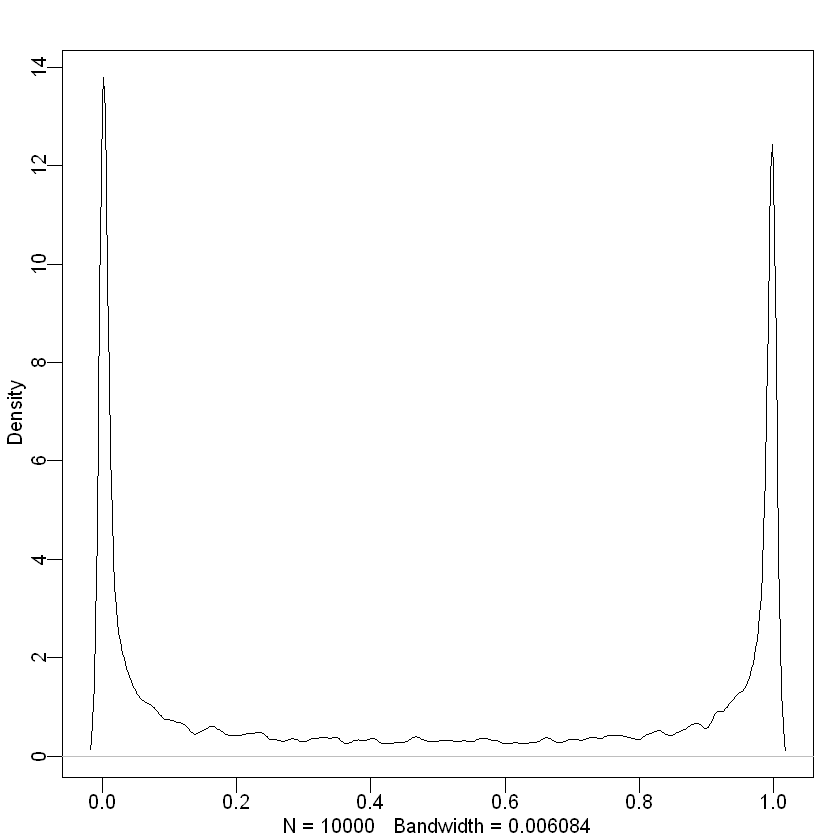

In [11]:
## R code 11.8
options(repr.plot.width=7,repr.plot.height=7)
dens( abs( p[,1] - p[,2] ) , adj=0.1 )

Now with treatment prior std dev =0.5

In [12]:
## R code 11.9
m11.3 <- quap(
    alist(
        pulled_left ~ dbinom( 1 , p ) ,
        logit(p) <- a + b[treatment] ,
        a ~ dnorm( 0 , 1.5 ),
        b[treatment] ~ dnorm( 0 , 0.5 )
    ) , data=d )

In [13]:
set.seed(1999)
prior <- extract.prior( m11.3 , n=1e4 )
p <- sapply( 1:4 , function(k) inv_logit( prior$a + prior$b[,k] ) )
mean( abs( p[,1] - p[,2] ) )

[1] 0.09838663

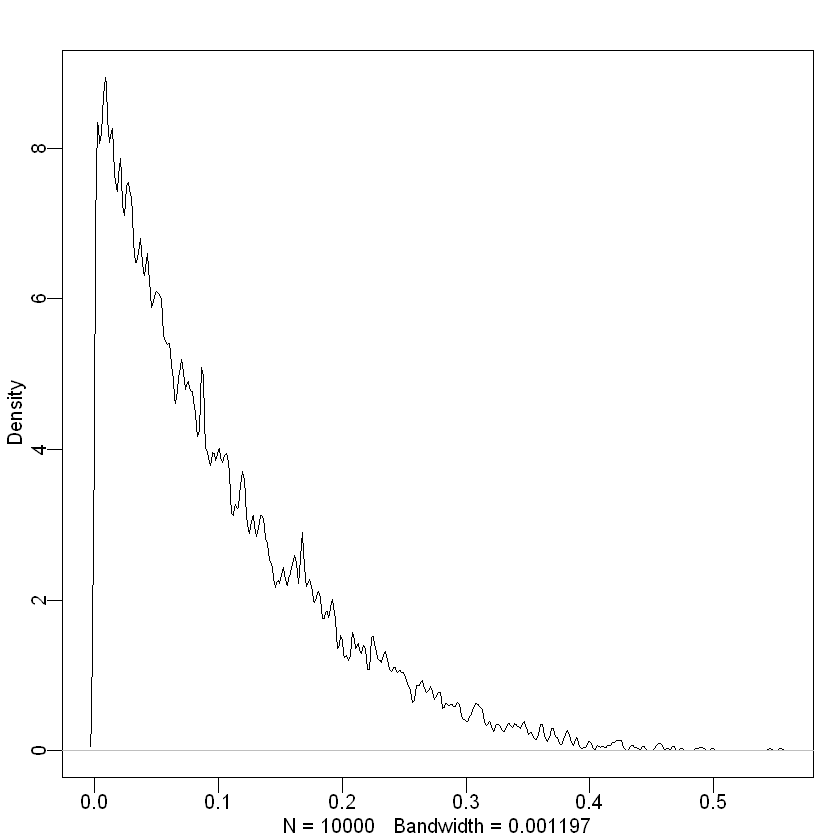

In [14]:
options(repr.plot.width=7,repr.plot.height=7)
dens( abs( p[,1] - p[,2] ),adj=0.1 )

# Logistic regression - MCMC sampling from the posterior

In [15]:
## R code 11.10
# trimmed data list
dat_list <- list(
    pulled_left = d$pulled_left,
    actor = d$actor,
    treatment = as.integer(d$treatment) )

In [16]:
## R code 11.11
m11.4 <- ulam(
    cmdstan=FALSE,
    alist(
        pulled_left ~ dbinom( 1 , p ) ,
        logit(p) <- a[actor] + b[treatment] ,
        a[actor] ~ dnorm( 0 , 1.5 ),
        b[treatment] ~ dnorm( 0 , 0.5 )
    ) , data=dat_list , chains=4 , log_lik=TRUE )


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 7.9e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1: Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.332 seconds (Warm-up)
Chain 1:                0.359 seconds (Sampling)
Chain 1:                0.691 seconds (

In [17]:
precis( m11.4 , depth=2 )

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a[1],-0.45452838,0.3278455,-0.97428979,0.05633733,618.6859,1.007790
a[2],3.87570394,0.7275517,2.76657713,5.14747922,1306.5162,1.002516
a[3],-0.75030298,0.3319683,-1.27857582,-0.22199795,658.6755,1.006012
a[4],-0.74646697,0.3353481,-1.28305292,-0.23289459,671.8760,1.010255
a[5],-0.45025996,0.3204826,-0.97250608,0.03983956,872.4934,1.001939
a[6],0.47748575,0.3135428,-0.01167141,0.98821730,629.0855,1.009149
a[7],1.95036354,0.4097641,1.29196633,2.60978487,986.1479,1.001770
b[1],-0.03940276,0.2789146,-0.47517233,0.39103998,683.5683,1.007147
b[2],0.48303991,0.2798537,0.04147342,0.91432370,633.8484,1.005394


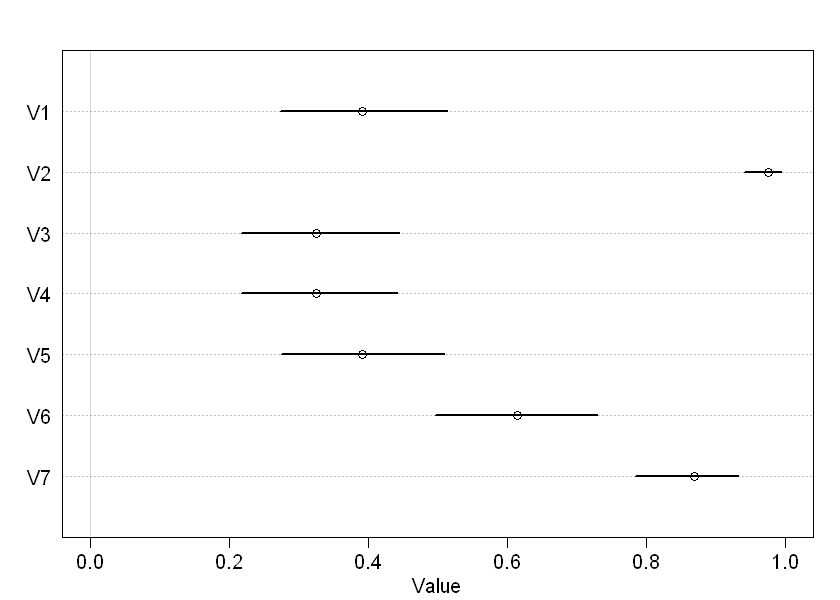

In [18]:
## R code 11.12
post <- extract.samples(m11.4)
p_left <- inv_logit( post$a )
options(repr.plot.width=7,repr.plot.height=5)
plot( precis( as.data.frame(p_left) ) , xlim=c(0,1) )

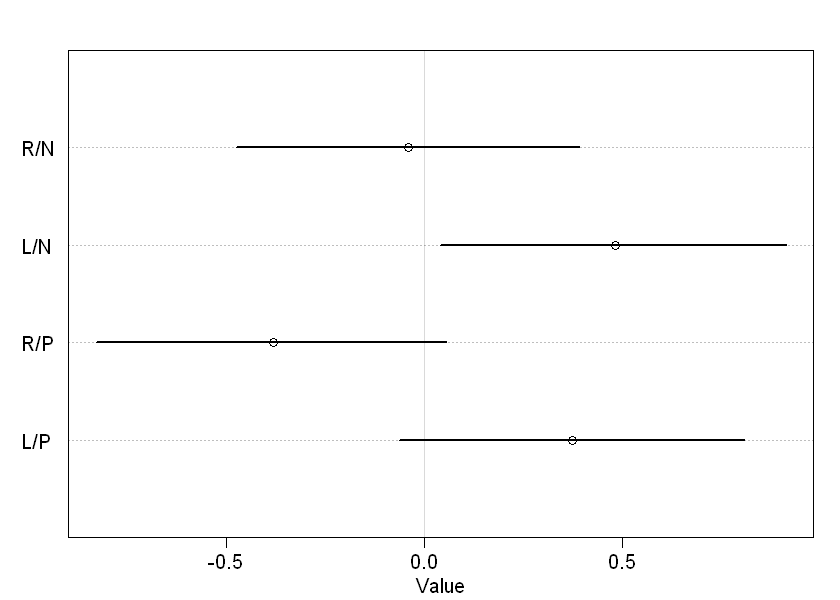

In [19]:
## R code 11.13
labs <- c("R/N","L/N","R/P","L/P")
options(repr.plot.width=7,repr.plot.height=5)
plot( precis( m11.4 , depth=2 , pars="b" ) , labels=labs )

L/N means "prosocial on left/no partner". R/P means "prosocial on right/partner". To understand these distributions, it'll
help to consider our expectations. What we are looking for is evidence that the chimpanzees choose the prosocial option more when a partner is present. 

This implies comparing the first row with the third row and the second row with the fourth row. You can probably see already that there isn't much evidence of prosocial intention in these data. 

But let's calculate  the differences between no-partner/partner and make sure.

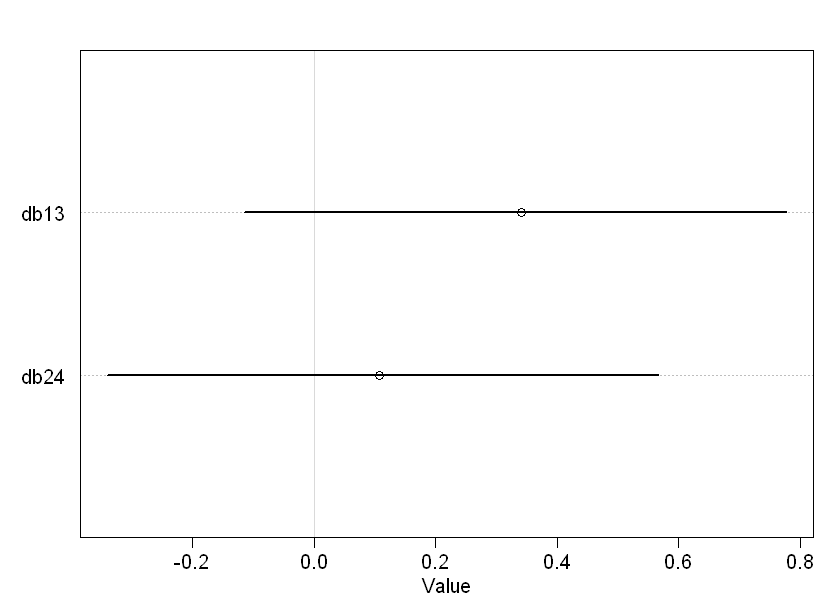

In [20]:
## R code 11.14
diffs <- list(
    db13 = post$b[,1] - post$b[,3],
    db24 = post$b[,2] - post$b[,4] )
options(repr.plot.width=7,repr.plot.height=5)
plot( precis(diffs) )

These are the constrasts between the no-partner/partner treatments. The scale is log-odds of pulling the left lever still. 

`db13` is the difference between no-partner/partner treatments when the prosocial option was on the right. So if there is evidence of more prosocial choice when partner is present, this will show up here as a larger difference, consistent with pulling right more when partner is present. There is indeed weak evidence that individuals pulled left more when the partner was absent, but the compatibility interval is quite wide. 

`db24` is the same difference, but for when the prosocial option was on the left. Now negative differences would be consistent with more prosocial choice when partner is present. Clearly that is not the case. If anything, individuals chose prosocial more when partner was absent. Overall, there isn't any compelling evidence of prosocial choice in this experiment.

Now let's consider a _posterior prediction check._ Let's summarize the proportions of left pulls for each actor in each treatment and then plot against the posterior predictions. 

First, calculate the proportion in each combination of actor and treatment in the original data:

In [21]:
## R code 11.15
pl <- as.matrix(by( d$pulled_left , list(d$actor,d$treatment) , mean,simplify=TRUE ))
attr(pl,"dimnames")<-NULL
attr(pl,"call")<-NULL
class(pl)<-c("matrix","array")
round(pl,3)

0.333,0.500,0.278,0.556
1.000,1.000,1.000,1.000
0.278,0.611,0.167,0.333
0.333,0.500,0.111,0.444
0.333,0.556,0.278,0.500
0.778,0.611,0.556,0.611
0.778,0.833,0.944,1.000


The result `pl` is a matrix with 7 rows and 4 columns. Each row is an individual chimpanzee (actor). Each column is a treatment. And the cells contain proportions of pulls that were of the left lever. 

Above is the first row, showing the proportions for the first actor. 

The model will make predictions for these values, so we can see how the posterior predictions look against the raw data. Remember that we don't want an exact match—that would mean overfitting. 

But we would like to understand how the model sees the data and learn from any anomalies.

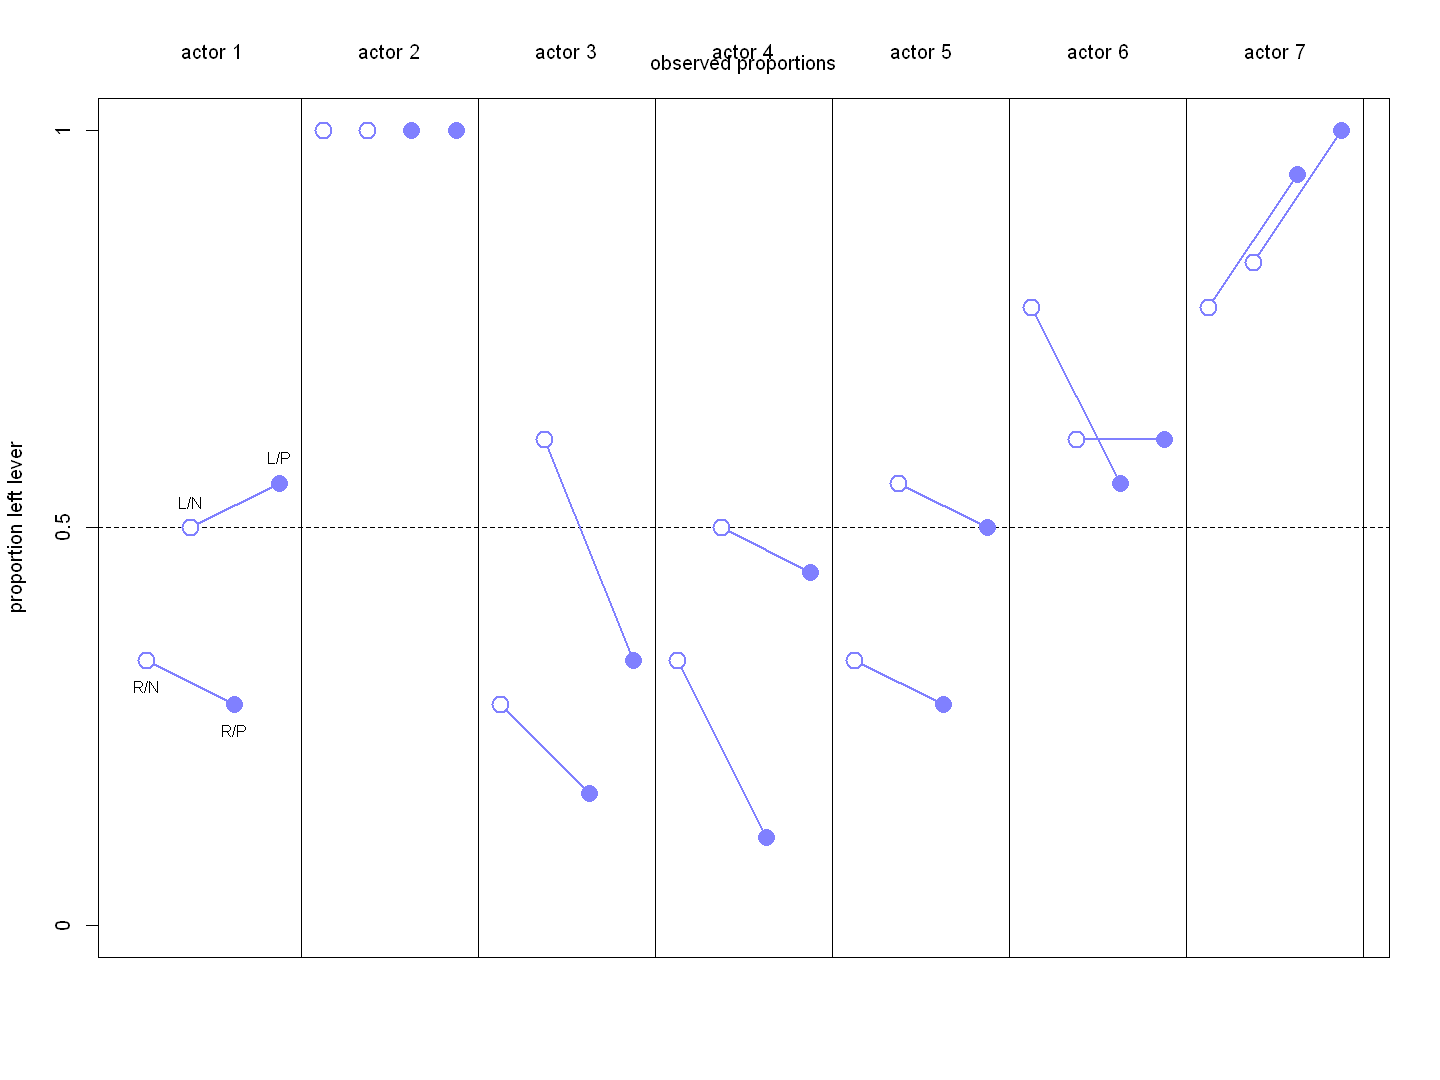

In [22]:
## R code 11.16
options(repr.plot.width=12,repr.plot.height=9)
plot( NULL , xlim=c(1,28) , ylim=c(0,1) , xlab="" ,
    ylab="proportion left lever" , xaxt="n" , yaxt="n" )
axis( 2 , at=c(0,0.5,1) , labels=c(0,0.5,1) )
abline( h=0.5 , lty=2 )
for ( j in 1:7 ) abline( v=(j-1)*4+4.5 , lwd=0.5 )
for ( j in 1:7 ) text( (j-1)*4+2.5 , 1.1 , concat("actor ",j) , xpd=TRUE )
for ( j in (1:7)[-2] ) {
    lines( (j-1)*4+c(1,3) , pl[j,c(1,3)] , lwd=2 , col=rangi2 )
    lines( (j-1)*4+c(2,4) , pl[j,c(2,4)] , lwd=2 , col=rangi2 )
}
points( 1:28 , t(pl) , pch=16 , col="white" , cex=1.9 )
points( 1:28 , t(pl) , pch=c(1,1,16,16) , col=rangi2 , lwd=2, cex=1.9 )
yoff <- 0.01
text( 1 , pl[1,1]-yoff , "R/N" , pos=1 , cex=0.8 )
text( 2 , pl[1,2]+yoff , "L/N" , pos=3 , cex=0.8 )
text( 3 , pl[1,3]-yoff , "R/P" , pos=1 , cex=0.8 )
text( 4 , pl[1,4]+yoff , "L/P" , pos=3 , cex=0.8 )
mtext( "observed proportions\n" )

In [23]:
## R code 11.17
dat <- list( actor=rep(1:7,each=4) , treatment=rep(1:4,times=7) )
p_post <- link( m11.4 , data=dat )
p_mu <- apply( p_post , 2 , mean )
p_ci <- apply( p_post , 2 , PI )

# Logistic regression - MCMC

In [24]:
## R code 11.18
d$side <- d$prosoc_left + 1 # right 1, left 2
d$cond <- d$condition + 1 # no partner 1, partner 2

In [25]:
## R code 11.19
dat_list2 <- list(
    pulled_left = d$pulled_left,
    actor = d$actor,
    side = d$side,
    cond = d$cond )

In [26]:
m11.5 <- ulam(
    cmdstan=FALSE,
    alist(
        pulled_left ~ dbinom( 1 , p ) ,
        logit(p) <- a[actor] + bs[side] + bc[cond] ,
        a[actor] ~ dnorm( 0 , 1.5 ),
        bs[side] ~ dnorm( 0 , 0.5 ),
        bc[cond] ~ dnorm( 0 , 0.5 )
    ) , data=dat_list2 , chains=4 , log_lik=TRUE )   #  'log_lik=TRUE' to allow Stan (ulam) to calculate LOOIS or WAIC


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 7.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1: Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.582 seconds (Warm-up)
Chain 1:                0.527 seconds (Sampling)
Chain 1:                1.109 seconds (

PSIS = "Pareto-smoothed importance sampling cross-validation" (a cross-validation statistics)

In [27]:
## R code 11.20
compare( m11.5 , m11.4 , func=PSIS )

,PSIS,SE,dPSIS,dSE,pPSIS,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m11.5,530.5934,19.18263,0.000000,NA,7.704792,0.7282215
m11.4,532.5646,18.93198,1.971236,1.299141,8.631794,0.2717785


In [28]:
## R code 11.20
compare( m11.5 , m11.4 , func=WAIC )

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m11.5,530.5394,19.15988,0.00000,NA,7.677800,0.7282902
m11.4,532.5113,18.91142,1.97193,1.298639,8.605149,0.2717098


In [29]:
# R code 11.20
compare( m11.5 , m11.4 , func=LOO )

,PSIS,SE,dPSIS,dSE,pPSIS,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m11.5,530.5934,19.18263,0.000000,NA,7.704792,0.7282215
m11.4,532.5646,18.93198,1.971236,1.299141,8.631794,0.2717785


In [30]:
## R code 11.21
post <- extract.samples( m11.4 , clean=FALSE )
str(post)

List of 4
 $ log_lik: num [1:2000, 1:504] -0.512 -0.473 -0.29 -0.534 -0.511 ...
 $ a      : num [1:2000, 1:7] -0.796 -0.194 -0.974 -0.608 -0.698 ...
 $ b      : num [1:2000, 1:4] 0.394 -0.309 -0.115 0.26 0.294 ...
 $ lp__   : num [1:2000(1d)] -267 -268 -270 -273 -268 ...
 - attr(*, "source")= chr "ulam posterior: 2000 samples from object"


In [31]:
stancode(m11.4)

data{
    array[504] int pulled_left;
    array[504] int treatment;
    array[504] int actor;
}
parameters{
     vector[7] a;
     vector[4] b;
}
model{
     vector[504] p;
    b ~ normal( 0 , 0.5 );
    a ~ normal( 0 , 1.5 );
    for ( i in 1:504 ) {
        p[i] = a[actor[i]] + b[treatment[i]];
        p[i] = inv_logit(p[i]);
    }
    pulled_left ~ binomial( 1 , p );
}
generated quantities{
    vector[504] log_lik;
     vector[504] p;
    for ( i in 1:504 ) {
        p[i] = a[actor[i]] + b[treatment[i]];
        p[i] = inv_logit(p[i]);
    }
    for ( i in 1:504 ) log_lik[i] = binomial_lpmf( pulled_left[i] | 1 , p[i] );
}



In [32]:
## R code 11.22
m11.4_stan_code <- stancode(m11.4)
m11.4_stan <- stan( model_code=m11.4_stan_code , data=dat_list , chains=4 )

data{
    array[504] int pulled_left;
    array[504] int treatment;
    array[504] int actor;
}
parameters{
     vector[7] a;
     vector[4] b;
}
model{
     vector[504] p;
    b ~ normal( 0 , 0.5 );
    a ~ normal( 0 , 1.5 );
    for ( i in 1:504 ) {
        p[i] = a[actor[i]] + b[treatment[i]];
        p[i] = inv_logit(p[i]);
    }
    pulled_left ~ binomial( 1 , p );
}
generated quantities{
    vector[504] log_lik;
     vector[504] p;
    for ( i in 1:504 ) {
        p[i] = a[actor[i]] + b[treatment[i]];
        p[i] = inv_logit(p[i]);
    }
    for ( i in 1:504 ) log_lik[i] = binomial_lpmf( pulled_left[i] | 1 , p[i] );
}


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 6.8e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Cha

In [33]:
compare( m11.4_stan , m11.4 )

Warning message in compare(m11.4_stan, m11.4):
"Not all model fits of same class.
This is usually a bad idea, because it implies they were fit by different algorithms.
Check yourself, before you wreck yourself."


,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m11.4_stan,532.0084,18.89705,0.0000000,NA,8.333763,0.5625351
m11.4,532.5113,18.91142,0.5029137,0.111972,8.605149,0.4374649


In [34]:
## R code 11.23
post <- extract.samples(m11.4)
mean( exp(post$b[,4]-post$b[,2]) )

[1] 0.9344572

# Logistic regression with aggregated data

In [35]:
## R code 11.24
data(chimpanzees)
d <- chimpanzees
d$treatment <- 1 + d$prosoc_left + 2*d$condition
d$side <- d$prosoc_left + 1 # right 1, left 2
d$cond <- d$condition + 1 # no partner 1, partner 2
d_aggregated <- aggregate(
    d$pulled_left ,
    list( treatment=d$treatment , actor=d$actor ,
          side=d$side , cond=d$cond ) ,
    sum )
colnames(d_aggregated)[5] <- "left_pulls"

In [36]:
head(d_aggregated)

,treatment,actor,side,cond,left_pulls
,<dbl>,<int>,<dbl>,<dbl>,<int>
1,1,1,1,1,6
2,1,2,1,1,18
3,1,3,1,1,5
4,1,4,1,1,6
5,1,5,1,1,6
6,1,6,1,1,14


In [37]:
## R code 11.25
dat <- with( d_aggregated , list(
    left_pulls = left_pulls,
    treatment = treatment,
    actor = actor,
    side = side,
    cond = cond ) )

In [38]:
m11.6 <- ulam(
    cmdstan=FALSE,    
    alist(
        left_pulls ~ dbinom( 18 , p ) ,
        logit(p) <- a[actor] + b[treatment] ,
        a[actor] ~ dnorm( 0 , 1.5 ) ,
        b[treatment] ~ dnorm( 0 , 0.5 )
    ) , data=dat , chains=4 , log_lik=TRUE )


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1: Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.043 seconds (Warm-up)
Chain 1:                0.037 seconds (Sampling)
Chain 1:                0.08 seconds (Tota

In [39]:
precis(m11.6,depth=2)

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a[1],-0.43524282,0.3349244,-0.99271485,0.06985630,595.8587,1.004768
a[2],3.88166443,0.7439820,2.76928308,5.12654859,1215.1551,1.002619
a[3],-0.74222146,0.3458104,-1.30417690,-0.20455884,671.6294,1.003079
a[4],-0.74156929,0.3356084,-1.27927854,-0.21416583,640.1288,1.005457
a[5],-0.44151691,0.3314547,-0.99411022,0.06296176,660.2078,1.003795
a[6],0.49004328,0.3369249,-0.05754514,1.03988955,747.9984,1.001492
a[7],1.97812909,0.4312653,1.30113963,2.68229867,933.4373,1.002767
b[1],-0.05208483,0.2904467,-0.50211857,0.42994952,606.1239,1.004669
b[2],0.48006684,0.2943675,0.01948375,0.96513710,640.4628,1.004369


In [40]:
## R code 11.26
compare( m11.6 , m11.4 , func=PSIS )

Warning message in compare(m11.6, m11.4, func = PSIS):
"Different numbers of observations found for at least two models.
Model comparison is valid only for models fit to exactly the same observations.
Number of observations for each model:
m11.6 28 
m11.4 504 
"
Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.



,PSIS,SE,dPSIS,dSE,pPSIS,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m11.6,114.1010,8.402184,0.0000,NA,8.372782,1.000000e+00
m11.4,532.5646,18.931982,418.4636,9.439002,8.631794,1.354547e-91


In [41]:
## R code 11.27
# deviance of aggregated 6-in-9
-2*dbinom(6,9,0.2,log=TRUE)
# deviance of dis-aggregated
-2*sum(dbern(c(1,1,1,1,1,1,0,0,0),0.2,log=TRUE))

[1] 11.79048

[1] 20.65212

In [42]:
LOO(m11.6,pointwise=TRUE) # different syntax  from the book draft - Not (still) documented in the package

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.



PSIS,lppd,penalty,std_err,k
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.9496512,-1.9748256,0.12686683,8.402184,0.3088487
1.1440361,-0.5720180,0.13146249,8.402184,0.3789438
3.7034070,-1.8517035,0.09224526,8.402184,0.3697451
3.7203684,-1.8601842,0.07109906,8.402184,0.4044780
3.9399427,-1.9699714,0.13379051,8.402184,0.3661083
6.9168615,-3.4584307,0.90514462,8.402184,0.6265727
5.2418614,-2.6209307,0.52215092,8.402184,0.5982386
3.8509496,-1.9254748,0.07647216,8.402184,0.3530675
0.6339291,-0.3169646,0.04488515,8.402184,0.2016119


# Multilevel treatment (Chapter 13)

Now we set a hierarchical model:

1. Varying intercepts $\alpha_{j}$, one for each of the 7 actors, but adding an adaptive prior with mean $\bar{\alpha}$.
2. The same $\beta_{j}$ coefficients, one for each of the 4 treatments (as in the previous version)
3. A second clustering factor, $[BLOCK]=1,\dots,6$. There are 6 blocks, each of 84 observations, $6\times 84=504$. Within each block there are $84=7\times (6+6)$ observations, 6 with no recipient and 6 with a partner, for each of the 7 actors.

The resulting model is:

$$
    \begin{array}{lcl}
    L_{i}                      &\sim &\operatorname{Binomial}(1,p_{i})\\[0.25cm]
    \operatorname{logit}(p_{i})&=    
           &\alpha_{\text{ACTOR}[i]}+\gamma_{\text{BLOCK}[i]}+\beta_{\text{TREATMENT}[i]}\\[0.25cm]
    \beta_{j}  &\sim &\operatorname{Normal}(0,0.5),\mskip30mu\text{for}\mskip7mu j=1,\dots,4,\\[0.25cm]
    \alpha_{j} &\sim &\operatorname{Normal}(\bar{\alpha},\sigma_{\alpha}),\mskip30mu\text{for}\mskip7mu j=1,\dots,7,\\[0.25cm]
    \gamma_{j} &\sim &\operatorname{Normal}(0,\sigma_{\gamma}),\mskip30mu\text{for}\mskip7mu j=1,\dots,6,\\[0.25cm]
    \bar{\alpha}     &\sim &\operatorname{Normal}(0,1.5),\\[0.25cm]
    \sigma_{\alpha}    &\sim &\operatorname{Exponential}(1),\\[0.25cm]
    \sigma_{\gamma}    &\sim &\operatorname{Exponential}(1).
    \end{array}
$$

In [43]:
## R code 13.21
require(rethinking)
data(chimpanzees)
d <- chimpanzees
d$treatment <- 1 + d$prosoc_left + 2*d$condition

In [44]:
dat_list <- list(
    pulled_left = d$pulled_left,
    actor = d$actor,
    block_id = d$block,
    treatment = as.integer(d$treatment) )

In [45]:
set.seed(13)
m13.4 <- ulam(
    cmdstan=FALSE,
    alist(
        pulled_left ~ dbinom( 1 , p ) ,
        logit(p) <- a[actor] + g[block_id] + b[treatment] ,
        b[treatment] ~ dnorm( 0 , 0.5 ),
      ## adaptive priors
        a[actor] ~ dnorm( a_bar , sigma_a ),
        g[block_id] ~ dnorm( 0 , sigma_g ),
      ## hyper-priors
        a_bar ~ dnorm( 0 , 1.5 ),
        sigma_a ~ dexp(1),
        sigma_g ~ dexp(1)
    ) , data=dat_list , chains=4 , cores=4 , log_lik=TRUE )

Warning message:
"There were 3 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"


In [46]:
## R code 13.22
precis( m13.4 , depth=2 )

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
b[1],-0.10571151,0.2912853,-0.58302516,0.35876720,645.6862,1.004818
b[2],0.42534087,0.3019959,-0.04503576,0.91392852,519.9028,1.006930
b[3],-0.44859334,0.2937052,-0.91392486,0.01067822,694.4587,1.001211
b[4],0.31028077,0.2975650,-0.17317412,0.78731935,646.1250,1.004643
a[1],-0.38248640,0.3478814,-0.92510867,0.18685334,650.1185,1.002637
a[2],4.64131026,1.2878007,3.01169534,6.98345095,890.3389,1.002352
a[3],-0.68902740,0.3569642,-1.24560739,-0.13225735,676.4517,1.003778
a[4],-0.69376374,0.3628796,-1.26271603,-0.09698361,663.2162,1.003055
a[5],-0.38612975,0.3547351,-0.93961253,0.18022578,747.0305,1.003362


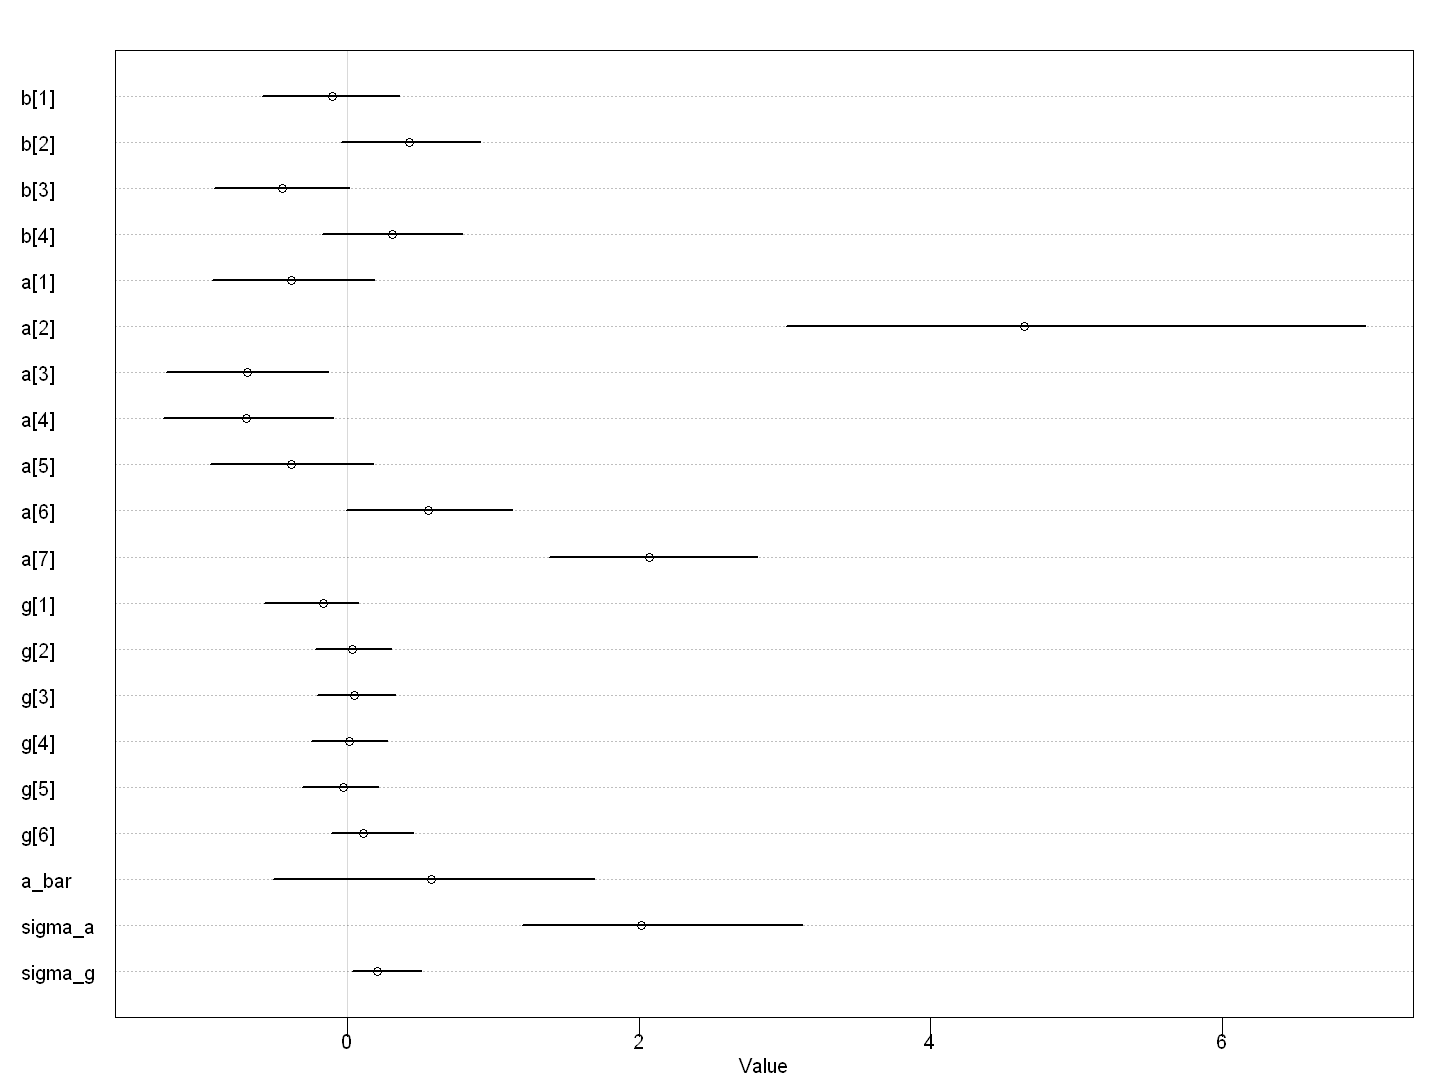

In [47]:
plot( precis(m13.4,depth=2) ) # also plot

In [48]:
sigma_a.samples<-extract.samples(m13.4,par="sigma_a")
str(sigma_a.samples)

List of 1
 $ sigma_a: num [1:2000(1d)] 1.94 1.2 1.13 4.21 1.35 ...
 - attr(*, "source")= chr "ulam posterior: 2000 samples from object"


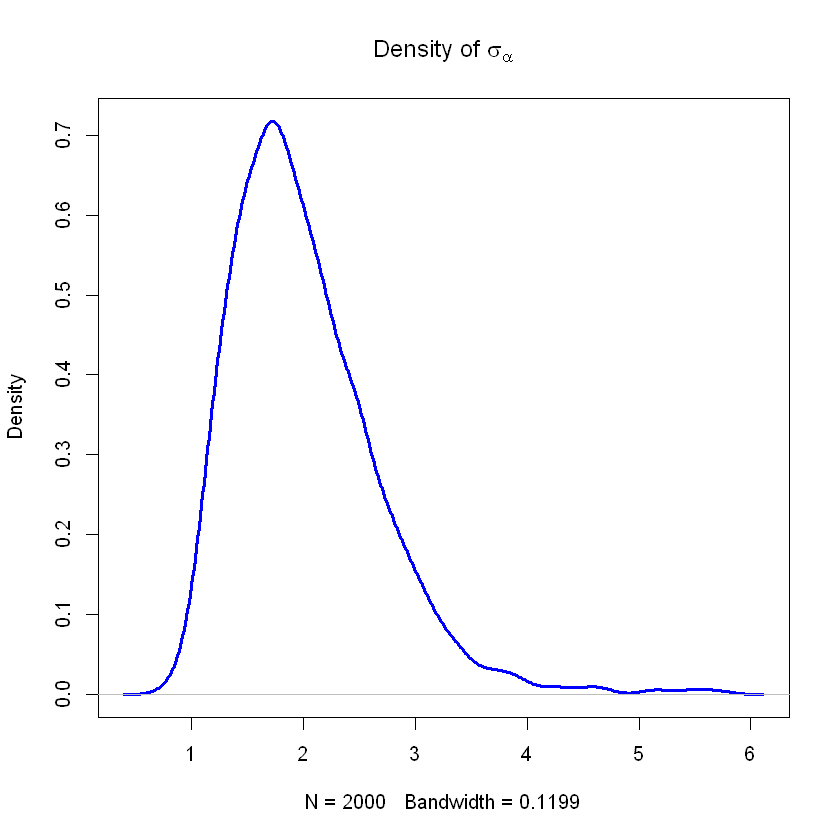

In [49]:
options(repr.plot.width=7,repr.plot.height=7)
plot(density(sigma_a.samples$sigma_a),lwd=2.5,col="blue",main=expression(paste("Density of ",sigma[alpha])))

In [50]:
sigma_g.samples<-extract.samples(m13.4,par="sigma_g")
str(sigma_g.samples)

List of 1
 $ sigma_g: num [1:2000(1d)] 0.1231 0.1052 0.0591 0.0631 0.1858 ...
 - attr(*, "source")= chr "ulam posterior: 2000 samples from object"


Plot $\sigma_{\gamma}$ on the same scale as $\sigma_{\alpha}$ to be able to visualize that variation among actors is much larger than among blocks.

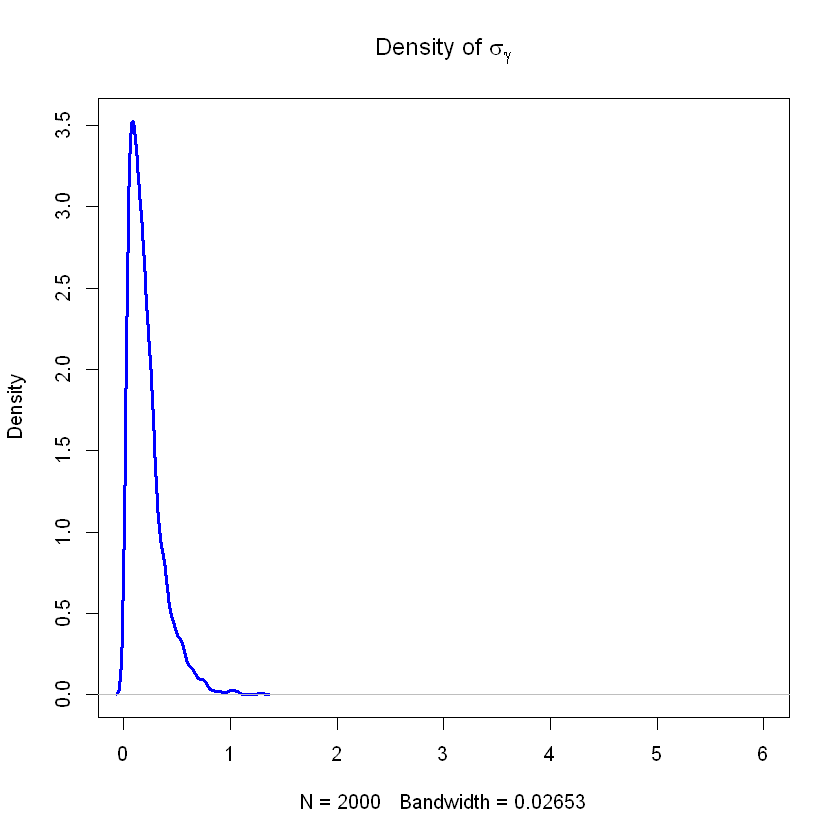

In [51]:
options(repr.plot.width=7,repr.plot.height=7)
plot(density(sigma_g.samples$sigma_g),lwd=2.5,col="blue",xlim=c(0,6),
     main=expression(paste("Density of ",sigma[gamma])))

Compare the model we have just fit to the following model, that ignores the BLOCK factor

In [52]:
## R code 13.23
set.seed(14)
m13.5 <- ulam(
    cmdstan=FALSE,
    alist(
        pulled_left ~ dbinom( 1 , p ) ,
        logit(p) <- a[actor] + b[treatment] ,
        b[treatment] ~ dnorm( 0 , 0.5 ),
        a[actor] ~ dnorm( a_bar , sigma_a ),
        a_bar ~ dnorm( 0 , 1.5 ),
        sigma_a ~ dexp(1)
    ) , data=dat_list , chains=4 , cores=4 , log_lik=TRUE )

In [53]:
## R code 13.24
compare( m13.4 , m13.5 )

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m13.5,531.3762,19.12630,0.0000000,NA,8.592136,0.6121209
m13.4,532.2886,19.32671,0.9124725,1.607122,10.596751,0.3878791


Relevant bit here is `pWAIC`, the effective number of parameters. While `m13.4` has 7 more parrameters than `m13.5` has, it has only about 2.5 more effective parameters. Why? Because the posterior distribution for `sigma_g` ended up close to zero. This means each of the 6 `g[]` parametersis strongly shrunk towards zero.

In contrast, the `a[]` parameters are shrunk towards zero much less, because the estimated variation across actors is much larger, resulting in less shrinkage. But as a consequence, each of the `a[]` parameters contributes much more to the `pWAIC`value.

You might also notice that the difference in WAIC between these models is small, less than 1. This is especially small compared the standard deviation of the difference, 1.6. These two models imply nearly identical predictions, and so their expected out-of-sample accuracy is nearly identical. The block parameters have been shrunk so much towards zero that they do
very little work in the model.

>If you are feeling the urge to **"select"** `m13.4` as the _best_ model, pause for a moment. There is nothing to gain here by selecting either model. The comparison of the two models tells a richer story —whether we include block or not hardly matters, and the `g[]` and `sigma_g` estimates tell us why. By retaining and reporting both models, we and our readers learn more
about the experiment. 

<span style="color:DarkCyan;font-size:22px">
    
McElreath's LAPIDARY DICTUM:
    
Model comparison is of value. 
    
Model selection, at least when we are pursuing scientific inference, is usually not.
</span>

### Even more clusters

The treatment effects, the `b` parameters, look a lot like the `a` and `g` parameters. Could we also use partial pooling on the treatment effects? Yes, we could:

$$
    \begin{array}{lcl}
    L_{i}                      &\sim &\operatorname{Binomial}(1,p_{i})\\[0.10cm]
    \operatorname{logit}(p_{i})&=    
           &\alpha_{\text{ACTOR}[i]}+\gamma_{\text{BLOCK}[i]}+\beta_{\text{TREATMENT}[i]}\\[0.10cm]
    \beta_{j}  &\sim &\operatorname{Normal}(0,\sigma_{\beta}),\mskip30mu\text{for}\mskip7mu j=1,\dots,4,\\[0.10cm]
    \alpha_{j} &\sim &\operatorname{Normal}(\bar{\alpha},\sigma_{\alpha}),\mskip30mu\text{for}\mskip7mu j=1,\dots,7,\\[0.10cm]
    \gamma_{j} &\sim &\operatorname{Normal}(0,\sigma_{\gamma}),\mskip30mu\text{for}\mskip7mu j=1,\dots,6,\\[0.10cm]
    \bar{\alpha}     &\sim &\operatorname{Normal}(0,1.5),\\[0.10cm]
    \sigma_{\alpha}    &\sim &\operatorname{Exponential}(1),\\[0.10cm]
    \sigma_{\gamma}    &\sim &\operatorname{Exponential}(1),\\[0.10cm]
    \sigma_{\beta}    &\sim &\operatorname{Exponential}(1).
    \end{array}
$$

In [54]:
## R code 13.25
set.seed(15)
m13.6 <- ulam(
    cmdstan=FALSE,
    alist(
        pulled_left ~ dbinom( 1 , p ) ,
        logit(p) <- a[actor] + g[block_id] + b[treatment] ,
        b[treatment] ~ dnorm( 0 , sigma_b ),
        a[actor] ~ dnorm( a_bar , sigma_a ),
        g[block_id] ~ dnorm( 0 , sigma_g ),
        a_bar ~ dnorm( 0 , 1.5 ),
        sigma_a ~ dexp(1),
        sigma_g ~ dexp(1),
        sigma_b ~ dexp(1)
    ) , data=dat_list , chains=4 , cores=4 , log_lik=TRUE )

Warning message:
"There were 13 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"
Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess"


In [55]:
precis(m13.6,depth=2)

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
b[1],-0.13736232,0.3807874,-0.69971097,0.39117358,150.1645,1.023937
b[2],0.35335574,0.3860101,-0.14696194,0.92607893,184.5976,1.017205
b[3],-0.46235572,0.3967848,-1.05175948,0.01451785,157.2731,1.019599
b[4],0.24383892,0.3797104,-0.24875567,0.80372220,174.7681,1.019955
a[1],-0.33426335,0.4209530,-0.95049742,0.28650532,193.2283,1.019688
a[2],4.69348439,1.3695110,3.02836017,6.98975437,403.3381,1.008437
a[3],-0.64558001,0.4304517,-1.25719517,-0.02071875,194.8894,1.015987
a[4],-0.64536195,0.4216700,-1.25913638,-0.01935673,180.2601,1.019653
a[5],-0.33505297,0.4237745,-0.93242526,0.28560730,202.3018,1.015686


In [56]:
#coeftab( m13.4 , m13.6 )

### Divergent transitions, the devil's funnel and non-centered priors

Example in page 732 of Radford Neal (2003) _"Slice sampling",_  Annals of Statistics **31(3),** 705-767. In that paper, Neal just calls it a "funnel". Apparently the _Devil_ appelative is McElreath's. The name is descriptive of the figure below, where the phenomenon can be observed.

A _divergent transition_ happens when the target pdf in an HMC simulation (the energy surface, in the physical analogy) is very steep in some region of the parameter space. Then it may happen that the total energy at the end of a displacement is not equal to the total energy at the beginning, due to a too coarse step size in the algorithm (relative to the surface slope).

Divergent transitions are rejected. They don't directly damage your approximation of the posterior distribution, but they do hurt it indirectly because the region where divergent transitions happen is hard to explore correctly. And even when there aren't any divergent transitions, distributions with steep regions are hard to explore. The chains will be less efficient.
And unfortunately The Devil's Funnel shows up quite often in multilevel models.

There are two easy tricks for reducing the impact of divergent transitions:

1. Tune the simulation. But for many models, you can never tune the sampler enough to remove the divergent transitions. 
2. Reparameterize the statistical model.

3. **Warning:** Switching to another sampler is a mistake. Gibbs sampler will never complain. It will just silently fail.


The following simple model demonstrates the problem and a possible solution:

$$
    \begin{array}{lcl}
    \nu   &\sim &\operatorname{Normal}(0,3),\\[0.15cm]
    x     &\sim &\operatorname{Normal}(0,\exp(\nu)).
    \end{array}
$$

In [57]:
## R code 13.26
m13.7 <- ulam(
    cmdstan=FALSE,
    alist(
        v ~ normal(0,3),
        x ~ normal(0,exp(v))
    ), data=list(N=1) , chains=4 )


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1: Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.02 seconds (Warm-up)
Chain 1:                0.013 seconds (Sampling)
Chain 1:                0.033 seconds (Tota

Warning message:
"There were 495 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"The largest R-hat is 1.75, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"
Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess"


In [58]:
precis( m13.7 )

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
v,-0.1665472,2.872116,-4.590292,4.03222,2.62801,2.206304
x,5.4254607,69.040835,-18.989308,13.17280,70.39428,1.066478


In [59]:
# Devil's Funnel from Chapter 13
U_funnel <- function( q , s=3 ) {
    v <- q[2]
    x <- q[1]
    U <- sum( dnorm(x,0,exp(v),log=TRUE) ) + dnorm(v,0,s,log=TRUE)
    return( -U )
}
U_funnel_gradient <- function( q , s=3 ) {
    v <- q[2]
    x <- q[1]
    Gv <- (-v)/s^2 - length(x) + exp(-2*v)*sum( x^2 ) #dU/dv
    Gx <- -exp(-2*v)*x #dU/dx
    return( c( -Gx , -Gv ) ) # negative bc energy is neg-log-prob
}

You may need to run this cell several times to see a divergent transition (overshooting the wall of the valley).

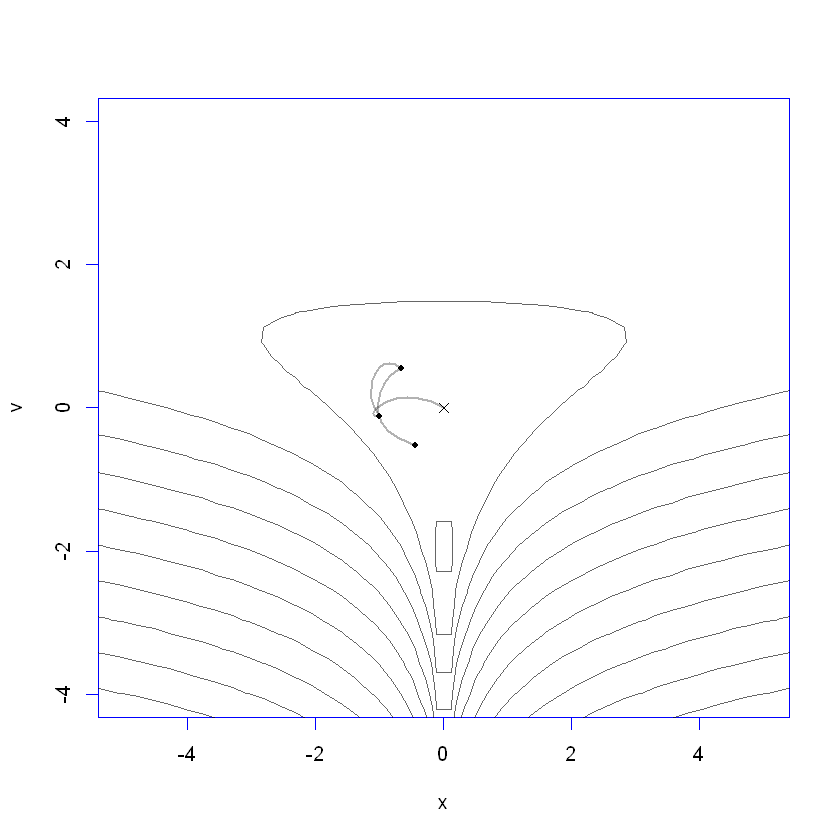

In [60]:
options(repr.plot.width=7,repr.plot.height=7)
old.par<-par(fg="blue")
HMC_2D_sample( n=3, U=U_funnel, U_gradient=U_funnel_gradient, 
  step=0.2 , L=10 , ylab="v"  , adj_lvls=1/12 )
par(old.par)

As $\nu$ changes, the distribution of $x$ changes in a very inconvenient way. This parameterization is known as the
_centered parameterization._ This is not a very intuitive name. It just indicates that the distribution of $x$ is 
conditional on one or more other parameters.

The alternative is _a non-centered parameterization._ A non-centered parameterization moves the embedded parameter, $\nu$
in this case, out of the definition of the other parameter. For The Devil's Funnel, we can accomplish that like this:

$$
    \begin{array}{lcl}
    \nu   &\sim &\operatorname{Normal}(0,3),\\[0.15cm]
     z    &\sim &\operatorname{Normal}(0,1),\\[0.15cm]
     x    &\sim &z\cdot\exp(\nu).
    \end{array}
$$

In [61]:
# Same, but with non-centered parameterization

U_funnel_NC <- function( q , s=3 ) {
    v <- q[2]
    z <- q[1]
    U <- sum( dnorm(z,0,1,log=TRUE) ) + dnorm(v,0,s,log=TRUE)
    return( -U )
}
U_funnel_NC_gradient <- function( q , s=3 ) {
    v <- q[2]
    z <- q[1]
    Gv <- (-v)/s^2 #dU/dv
    Gz <- (-z) #dU/dz
    return( c( -Gz , -Gv ) ) # negative bc energy is neg-log-prob
}

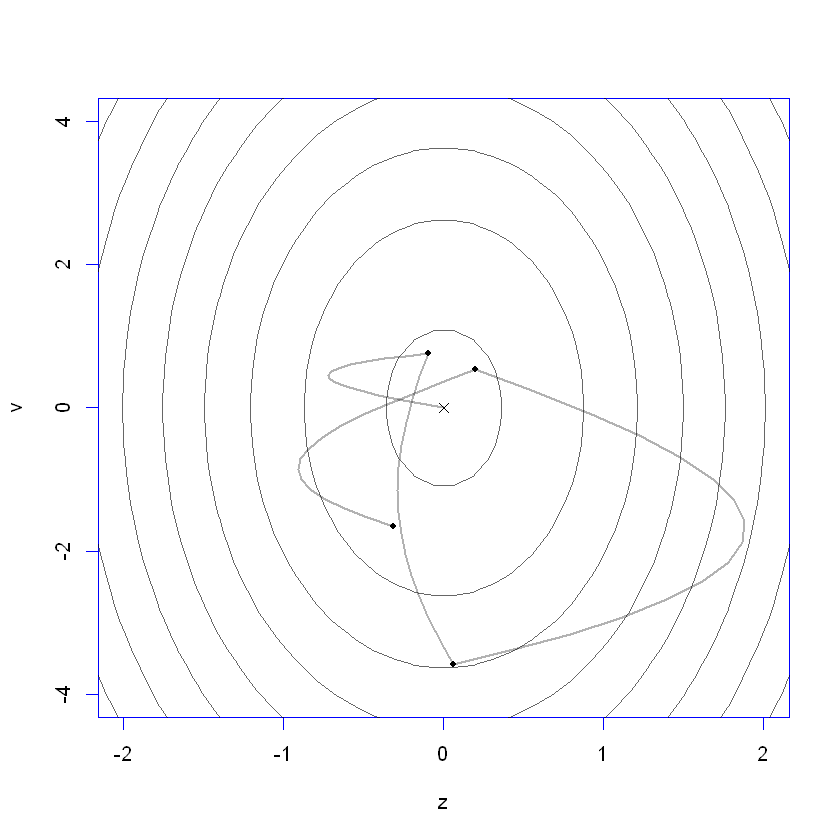

In [62]:
options(repr.plot.width=7,repr.plot.height=7)
old.par<-par(fg="blue")
HMC_2D_sample( n=4 , U=U_funnel_NC , U_gradient=U_funnel_NC_gradient , 
  step=0.2 , L=15 , ylab="v" , xlab="z" , xlim=c(-2,2) , nlvls=12 , adj_lvls=1 )
par(old.par)

Here is the simulation for the non-centered model. The `gq>` syntax directs `ulam` to send the following statement to the 
```
generated quantities
```
block in the Stan program. The colon in this line is required by `ulam`. Apparently this is true also of the "superassignment" operator `<<-`, but it doesn't seem to be documented. As a matter of fact `<-` was deprecated in Stan quite a long time ago.

In [63]:
## R code 13.27
m13.7nc <- ulam(
    cmdstan=FALSE,
    alist(
        v ~ normal(0,3),
        z ~ normal(0,1),
        gq> real[1]:x <<- z*exp(v)
    ), data=list(N=1) , chains=4 )


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1: Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.005 seconds (Warm-up)
Chain 1:                0.004 seconds (Sampling)
Chain 1:                0.009 seconds (

In [64]:
precis( m13.7nc )

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
v,0.01230349,2.996025,-4.796048,4.771022,1488.635,1.0010843
z,0.01210140,1.039122,-1.627722,1.666582,1408.636,0.9992154
x,-3.79610011,709.000162,-30.965837,25.392441,1785.328,1.0012075


### Non-centered chimpanzees

First we try to tune the simulation by increasing the `adapt_delta` control variable closer to 1.

In [65]:
## R code 13.28
set.seed(13)
m13.4b <- ulam( m13.4 , cmdstan=FALSE, chains=4 , cores=4 , control=list(adapt_delta=0.99) )

Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"
Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess"


The `divergent()` function is not documented in the current `rethinking` package version (2.31),   
but it is there and seems to work, giving the obvious result.   
It shows some improvement on the previous model, but the problem is still there.

In [66]:
divergent(m13.4b)  

[1] 0

Now we use the non-centered reparameterization, adding two sets of $\operatorname{Normal}(0,1)$ variables, vector $z$ gives the standardized intercept for each actor, $z_{j}$, $j=1,\dots,7$ and the vector x gives the standardized intercept for each block
$x_{j}$, $j=1,\dots,6$.

$$
    \begin{array}{lcl}
    L_{i}                      &\sim &\operatorname{Binomial}(1,p_{i})\\[0.10cm]
    \operatorname{logit}(p_{i})&=&\bar{\alpha}+
           z_{\text{ACTOR}[i]}\cdot\sigma_{\alpha}+x_{\text{BLOCK}[i]}\cdot\sigma_{\gamma}
           +\beta_{\text{TREATMENT}[i]}\\[0.10cm]
    \beta_{j}  &\sim &\operatorname{Normal}(0,0.5),\mskip30mu\text{for}\mskip7mu j=1,\dots,4,\\[0.10cm]
         z_{j} &\sim &\operatorname{Normal}(0,1),\mskip30mu\text{for}\mskip7mu j=1,\dots,7,\\[0.10cm]
         x_{j} &\sim &\operatorname{Normal}(0,1),\mskip30mu\text{for}\mskip7mu j=1,\dots,6,\\[0.10cm]
    \bar{\alpha}     &\sim &\operatorname{Normal}(0,1.5),\\[0.10cm]
    \sigma_{\alpha}    &\sim &\operatorname{Exponential}(1),\\[0.10cm]
    \sigma_{\gamma}    &\sim &\operatorname{Exponential}(1).
    \end{array}
$$

Each actor intercept is defined by $\alpha_{j}=\bar{\alpha} + z_{j}\cdot \sigma_{\alpha}$, and each block intercept by
$\gamma_{j}=x_{j}\cdot\sigma_{\gamma}$. So these expressions appear now in the linear model.

In [67]:
## R code 13.29
set.seed(13)
m13.4nc <- ulam(
    cmdstan=FALSE,
    alist(
        pulled_left ~ dbinom( 1 , p ) ,
        logit(p) <- a_bar + z[actor]*sigma_a + # actor intercepts
                    x[block_id]*sigma_g +      # block intercepts
                    b[treatment] ,
        b[treatment] ~ dnorm( 0 , 0.5 ),
        z[actor] ~ dnorm( 0 , 1 ),
        x[block_id] ~ dnorm( 0 , 1 ),
        a_bar ~ dnorm( 0 , 1.5 ),
        sigma_a ~ dexp(1),
        sigma_g ~ dexp(1),
        gq> vector[actor]:a <<- a_bar + z*sigma_a,
        gq> vector[block_id]:g <<- x*sigma_g
    ) , data=dat_list , chains=4 , cores=4 )

Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"


In [68]:
## R code 13.30
precis_c <- precis( m13.4 , depth=2 )

In [69]:
precis_nc <- precis( m13.4nc , depth=2 )

Number of effective samples for each effect in both parameterizations. Most effects get a larger `n_eff` in the non-centered one.

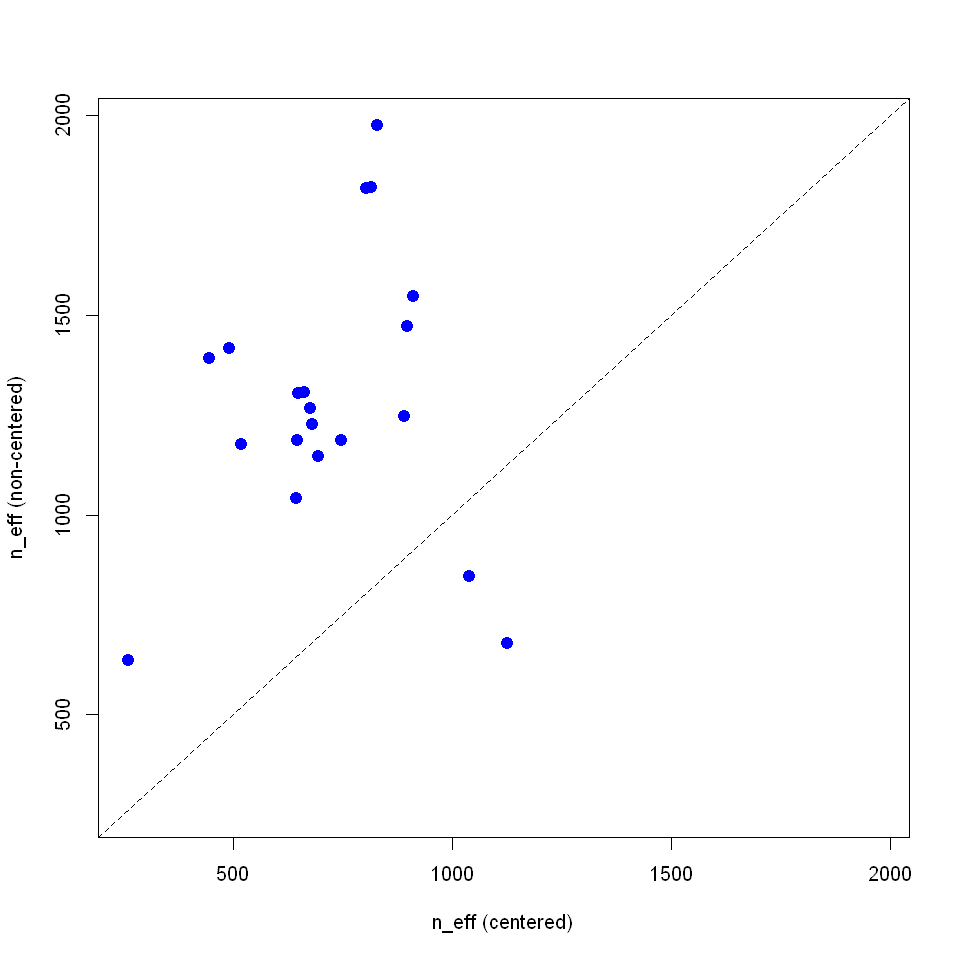

In [70]:
options(repr.plot.width=8,repr.plot.height=8)
pars <- c( paste("a[",1:7,"]",sep="") , paste("g[",1:6,"]",sep="") ,
           paste("b[",1:4,"]",sep="") , "a_bar" , "sigma_a" , "sigma_g" )
neff_table <- cbind( precis_c[pars,"n_eff"] , precis_nc[pars,"n_eff"] )
plot( neff_table , xlim=range(neff_table) , ylim=range(neff_table) ,
    xlab="n_eff (centered)" , ylab="n_eff (non-centered)" , pch=19,cex=1.3,col="blue" )
abline( a=0 , b=1 , lty=2 )

### Posterior predictions

Predictions for actor 2. **Caution:** This is the chimp always pulling the left lever.

The `link()` function is essentially the `predict()` method for `ulam` objects. Currently only partially documented. To use it we prepare a `newdata` list, repeating `actor` number = 2 and `block` number, e.g., = 1.

In [71]:
## R code 13.31
chimp <- 2
d_pred <- list(
    actor = rep(chimp,4),
    treatment = 1:4,
    block_id = rep(1,4)
)
p <- link( m13.4 , data=d_pred )
p_mu <- apply( p , 2 , mean )
p_ci <- apply( p , 2 , PI )

Mean and percentile intervals (PI) 

In [72]:
round(p_mu,2)
round(p_ci,2)

[1] 0.98 0.99 0.97 0.99

5%,0.94,0.96,0.92,0.96
94%,1.00,1.00,1.00,1.00


Same as above, now "by hand", step by step.

In [73]:
## R code 13.32
post <- extract.samples(m13.4)
str(post)

List of 6
 $ b      : num [1:2000, 1:4] 0.107 -0.117 -0.103 -0.224 -0.165 ...
 $ a      : num [1:2000, 1:7] -0.324 -0.557 0.488 -0.471 -0.442 ...
 $ g      : num [1:2000, 1:6] -0.2294 -0.2155 -0.0243 -0.023 -0.1224 ...
 $ a_bar  : num [1:2000(1d)] 0.324 0.363 1.077 0.847 1.933 ...
 $ sigma_a: num [1:2000(1d)] 1.94 1.2 1.13 4.21 1.35 ...
 $ sigma_g: num [1:2000(1d)] 0.1231 0.1052 0.0591 0.0631 0.1858 ...
 - attr(*, "source")= chr "ulam posterior: 2000 samples from object"


For instance, the posterior density for actor 5

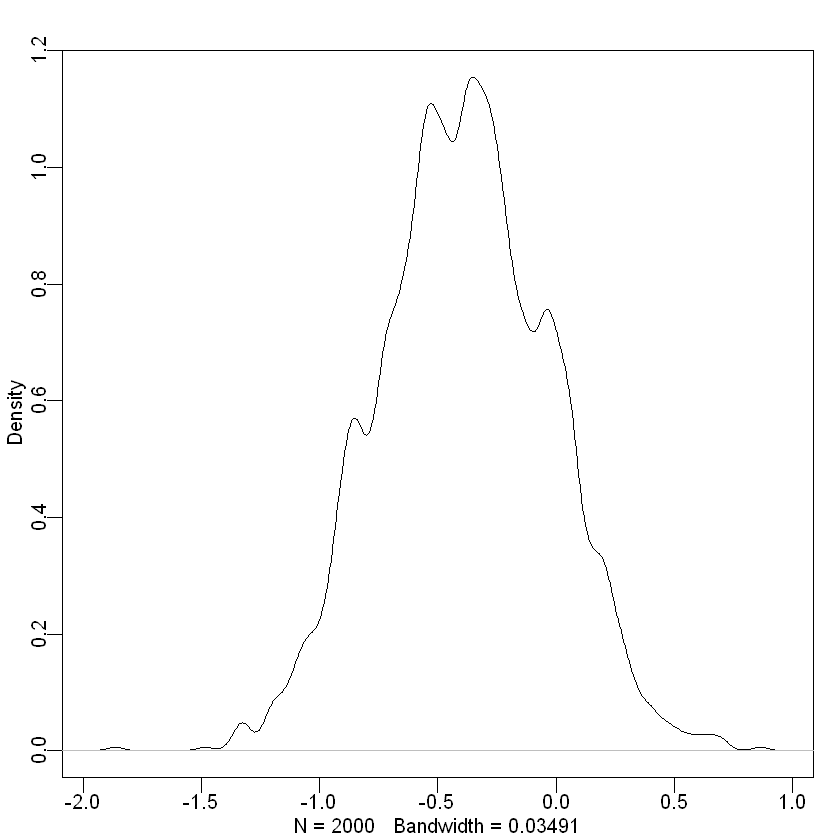

In [74]:
## R code 13.33
options(repr.plot.width=7,repr.plot.height=7)
dens( post$a[,5] )

In [75]:
## R code 13.34
p_link <- function( treatment , actor=1 , block_id=1 ) {
    logodds <- with( post ,
        a[,actor] + g[,block_id] + b[,treatment] )
    return( inv_logit(logodds) )
}

In [76]:
## R code 13.35
p_raw <- sapply( 1:4 , function(i) p_link( i , actor=2 , block_id=1 ) )
p_mu <- apply( p_raw , 2 , mean )
p_ci <- apply( p_raw , 2 , PI )

Mean and percentile intervals (PI) 

In [77]:
round(p_mu,2)
round(p_ci,2)

[1] 0.98 0.99 0.97 0.99

5%,0.94,0.96,0.92,0.96
94%,1.00,1.00,1.00,1.00


### Posterior prediction for new clusters

In [78]:
## R code 13.36
p_link_abar <- function( treatment ) {
    logodds <- with( post , a_bar + b[,treatment] )
    return( inv_logit(logodds) )
}

In [79]:
## R code 13.37
post <- extract.samples(m13.4)
p_raw <- sapply( 1:4 , function(i) p_link_abar( i ) )
p_mu <- apply( p_raw , 2 , mean )
p_ci <- apply( p_raw , 2 , PI )

Mean and percentile intervals (PI) 

In [80]:
round(p_mu,2)
round(p_ci,2)

[1] 0.60 0.71 0.53 0.69

5%,0.34,0.47,0.28,0.45
94%,0.83,0.90,0.78,0.89


In [81]:
str(p_ci)

 num [1:2, 1:4] 0.344 0.831 0.471 0.895 0.278 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:2] "5%" "94%"
  ..$ : NULL


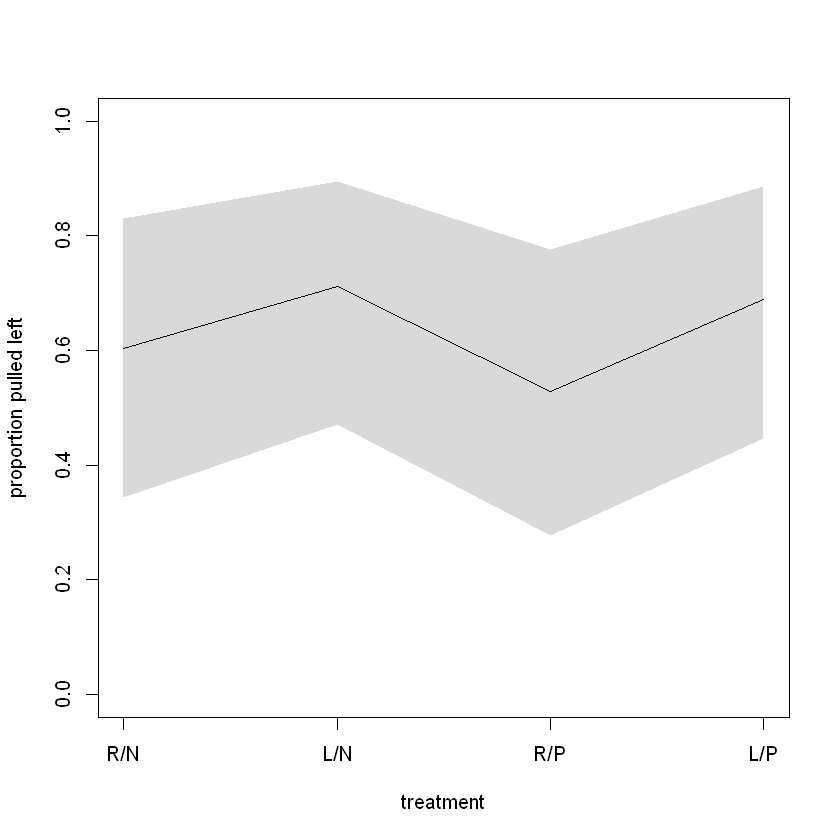

In [82]:
options(repr.plot.width=7,repr.plot.height=7)
plot(NULL,xlab="treatment",ylab="proportion pulled left",ylim=c(0,1),xaxt="n",xlim=c(1,4))
axis( 1 , at=1:4 , labels=c("R/N","L/N","R/P","L/P") )
lines( 1:4 , p_mu )
shade(as.matrix(p_ci), 1:4 )

In [83]:
## R code 13.38
a_sim <- with( post , rnorm( length(post$a_bar) , a_bar , sigma_a ) )
p_link_asim <- function( treatment ) {
    logodds <- with( post , a_sim + b[,treatment] )
    return( inv_logit(logodds) )
}
p_raw_asim <- sapply( 1:4 , function(i) p_link_asim( i ) )

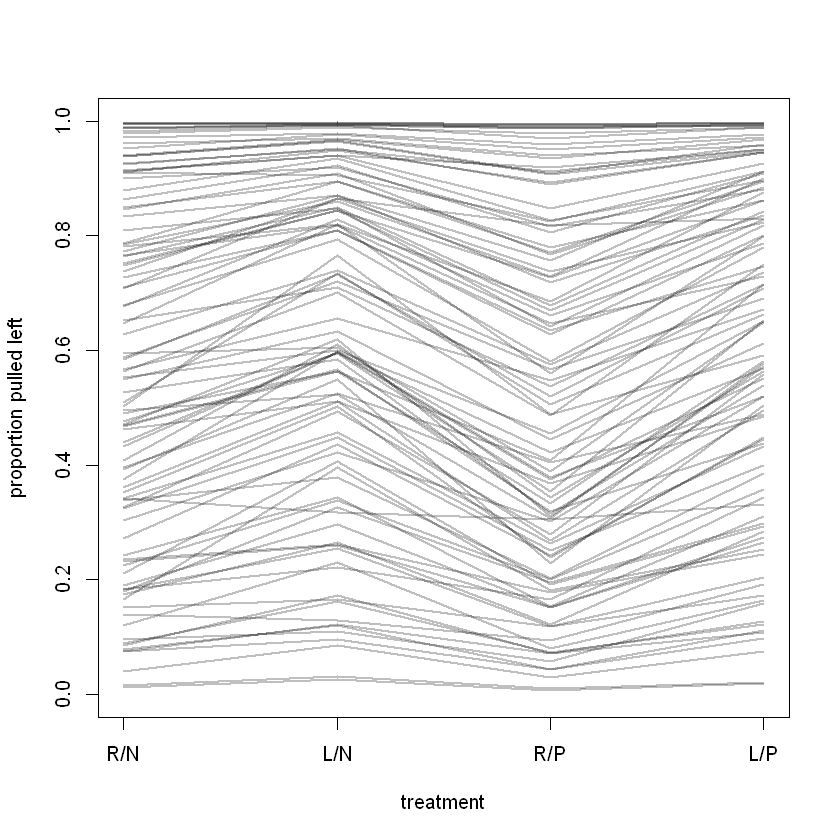

In [84]:
## R code 13.39
options(repr.plot.width=7,repr.plot.height=7)
plot( NULL , xlab="treatment" , ylab="proportion pulled left" ,
    ylim=c(0,1) , xaxt="n" , xlim=c(1,4) )
axis( 1 , at=1:4 , labels=c("R/N","L/N","R/P","L/P") )
for ( i in 1:100 ) lines( 1:4 , p_raw_asim[i,] , col=grau(0.25) , lwd=2 )

## R code 13.40
## R code 13.41